## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import SqueezeNet

In [2]:
import helper_utils

In [3]:
dataset = helper_utils.get_dataset()

transform = transforms.ToTensor()
dataset.transform = transform

100%|██████████| 26.4M/26.4M [00:10<00:00, 2.62MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 148kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.5MB/s]


In [4]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [5]:
img_batch, label_batch = next(iter(dataloader))
print("Batch shape:", img_batch.shape)  # Should be [batch_size, 1, 28, 28]

Batch shape: torch.Size([64, 1, 28, 28])


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block
        self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Block
        # For Fashion MNIST: input images are 28x28,
        # after conv+pool: 32x14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for Fashion MNIST

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
simple_cnn = SimpleCNN()

try:
    output = simple_cnn(img_batch)  
except Exception as e:
    print(f"\033[91mError during forward pass: {e}\033[0m")

Error during forward pass: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


In [8]:
class SimpleCNNDebug(SimpleCNN):
    def __init__(self):
        super().__init__()
        # The super().__init__() call above properly initializes all layers from SimpleCNN
        # No need to redefine the layers here

    def forward(self, x):
        print("Input shape:", x.shape)
        print(
            " (Layer components) Conv layer parameters (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activation) After convolution and ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activation) After pooling:", x_pool.shape)

        print(
            "(Layer components) Linear layer fc1 parameters (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        x_fc1 = self.relu_fc(self.fc1(x_pool))

        print("===")

        print("(Activation) After fc1 and ReLU:", x_fc1.shape)

        print(
            "(Layer components) Linear layer fc2 parameters (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activation) After fc2 (output):", x.shape)
        return x

In [9]:
simple_cnn_debug = SimpleCNNDebug()

try:
    output_debug = simple_cnn_debug(img_batch)  
except Exception as e:
    print(f"\033[91mError during forward pass in debug model: {e}\033[0m")

Input shape: torch.Size([64, 1, 28, 28])
 (Layer components) Conv layer parameters (weights, biases): torch.Size([32, 1, 3, 3]) torch.Size([32])
===
(Activation) After convolution and ReLU: torch.Size([64, 32, 28, 28])
(Activation) After pooling: torch.Size([64, 32, 14, 14])
(Layer components) Linear layer fc1 parameters (weights, biases): torch.Size([128, 6272]) torch.Size([128])
Error during forward pass in debug model: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


In [10]:
class SimpleCNNFixed(SimpleCNN):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print("Input shape:", x.shape)
        print(
            " (Neuron components) Conv layer parameters (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activation) After convolution and ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activation) After pooling:", x_pool.shape)

        x_flattened = torch.flatten(
            x_pool, start_dim=1
        )  # Flatten all dimensions except batch
        print("(Activation) After flattening:", x_flattened.shape)

        print(
            "(Neuron components) Linear layer fc1 parameters (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        x_fc1 = self.relu_fc(self.fc1(x_flattened))

        print("===")

        print("(Activation) After fc1 and ReLU:", x_fc1.shape)

        print(
            "(Neuron components) Linear layer fc2 parameters (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activation) After fc2 (output):", x.shape)
        return x

In [11]:
# Fixed version
simple_cnn_fixed = SimpleCNNFixed()

output = simple_cnn_fixed(img_batch)

Input shape: torch.Size([64, 1, 28, 28])
 (Neuron components) Conv layer parameters (weights, biases): torch.Size([32, 1, 3, 3]) torch.Size([32])
===
(Activation) After convolution and ReLU: torch.Size([64, 32, 28, 28])
(Activation) After pooling: torch.Size([64, 32, 14, 14])
(Activation) After flattening: torch.Size([64, 6272])
(Neuron components) Linear layer fc1 parameters (weights, biases): torch.Size([128, 6272]) torch.Size([128])
===
(Activation) After fc1 and ReLU: torch.Size([64, 128])
(Neuron components) Linear layer fc2 parameters (weights, biases): torch.Size([10, 128]) torch.Size([10])
===
(Activation) After fc2 (output): torch.Size([64, 10])


In [12]:
class SimpleCNN2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional Block
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Block
        # For Fashion MNIST: input images are 28x28,
        # after conv+pool: 32x14x14
        flattened_size = 32 * 14 * 14
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 10),  # 10 classes for Fashion MNIST
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_block(x)
        return x

In [13]:
simple_cnn_seq = SimpleCNN2Seq()
output = simple_cnn_seq(img_batch)

print("Output shape from sequential model:", output.shape)

Output shape from sequential model: torch.Size([64, 10])


In [14]:
class SimpleCNN2SeqDebug(SimpleCNN2Seq):
    def __init__(self):
        super().__init__()
        # The super().__init__() call above properly initializes all layers from SimpleCNN2Seq
        # No need to redefine the layers here

    def get_statistics(self, activation):
        mean = activation.mean().item()
        std = activation.std().item()
        min_val = activation.min().item()
        max_val = activation.max().item()

        print(f" Mean: {mean}")
        print(f" Std: {std}")
        print(f" Min: {min_val}")
        print(f" Max: {max_val}")
        return mean, std, min_val, max_val

    def forward(self, x):
        features = self.conv_block(x)
        x = torch.flatten(features, start_dim=1)  # Flatten all dimensions except batch

        print("After conv_block, the activation statistics are:")
        self.get_statistics(features)

        x = self.fc_block(x)
        print("After fc_block, the activation statistics are:")
        self.get_statistics(x)
        return x

In [15]:
simple_cnn_seq_debug = SimpleCNN2SeqDebug()

for idx, (img_batch, _) in enumerate(dataloader):
    if idx < 5:
        print(f"=== Batch {idx} ===")
        output_debug = simple_cnn_seq_debug(img_batch)

=== Batch 0 ===
After conv_block, the activation statistics are:
 Mean: 0.12046638876199722
 Std: 0.18475042283535004
 Min: 0.0
 Max: 1.2888575792312622
After fc_block, the activation statistics are:
 Mean: 0.01372190099209547
 Std: 0.07318729907274246
 Min: -0.1303226500749588
 Max: 0.21076297760009766
=== Batch 1 ===
After conv_block, the activation statistics are:
 Mean: 0.123245969414711
 Std: 0.18926472961902618
 Min: 0.0
 Max: 1.2555723190307617
After fc_block, the activation statistics are:
 Mean: 0.012401294894516468
 Std: 0.07466476410627365
 Min: -0.1316453218460083
 Max: 0.21607130765914917
=== Batch 2 ===
After conv_block, the activation statistics are:
 Mean: 0.12295569479465485
 Std: 0.18912628293037415
 Min: 0.0
 Max: 1.2826837301254272
After fc_block, the activation statistics are:
 Mean: 0.012818741612136364
 Std: 0.07590784877538681
 Min: -0.13092458248138428
 Max: 0.21387016773223877
=== Batch 3 ===
After conv_block, the activation statistics are:
 Mean: 0.1213427782

### Architecture Overview

In [16]:
# Load SqueezeNet model
complex_model = SqueezeNet()

print(complex_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [17]:
# Iterate through the main blocks
for name, block in complex_model.named_children():
    print(f"Block {name} has a total of {len(list(block.children()))} layers:")
    
    # List all children layers in the block
    for idx, layer in enumerate(block.children()):
        # Check if the layer is terminal (no children) or not
        if len(list(layer.children())) == 0:
            print(f"\t {idx} - Layer {layer}")
        # If the layer has children, it's a sub-block, then print only the number of children and its name
        else:
            layer_name = layer._get_name()  # More user-friendly name
            print(f"\t {idx} - Sub-block {layer_name} with {len(list(layer.children()))} layers")            

Block features has a total of 13 layers:
	 0 - Layer Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
	 1 - Layer ReLU(inplace=True)
	 2 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 3 - Sub-block Fire with 6 layers
	 4 - Sub-block Fire with 6 layers
	 5 - Sub-block Fire with 6 layers
	 6 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 7 - Sub-block Fire with 6 layers
	 8 - Sub-block Fire with 6 layers
	 9 - Sub-block Fire with 6 layers
	 10 - Sub-block Fire with 6 layers
	 11 - Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 12 - Sub-block Fire with 6 layers
Block classifier has a total of 4 layers:
	 0 - Layer Dropout(p=0.5, inplace=False)
	 1 - Layer Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
	 2 - Layer ReLU(inplace=True)
	 3 - Layer AdaptiveAvgPool2d(output_size=(1, 1))


In [18]:
first_fire_module = complex_model.features[3]

for idx, module in enumerate(first_fire_module.modules()):
    # Avoid printing the top-level module itself
    if idx > 0 :
        print(module)

Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)


### Detail Inspection

You will now count how many `Conv2d` layers are in the model.

In [19]:
type_layer = nn.Conv2d

selected_layers = [layer for layer in complex_model.modules() if isinstance(layer, type_layer)]

print(f"Number of {type_layer.__name__} layers: {len(selected_layers)}")

Number of Conv2d layers: 26


You will now count the total number of parameters in the model.
This gives you an idea of the model's complexity and capacity.

In [20]:
# total number of parameters in the model
total_params = sum(p.numel() for p in complex_model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 1248424


Layer features.0 has 14208 parameters
Layer features.1 has 0 parameters
Layer features.2 has 0 parameters
Layer features.3.squeeze has 1552 parameters
Layer features.3.squeeze_activation has 0 parameters
Layer features.3.expand1x1 has 1088 parameters
Layer features.3.expand1x1_activation has 0 parameters
Layer features.3.expand3x3 has 9280 parameters
Layer features.3.expand3x3_activation has 0 parameters
Layer features.4.squeeze has 2064 parameters
Layer features.4.squeeze_activation has 0 parameters
Layer features.4.expand1x1 has 1088 parameters
Layer features.4.expand1x1_activation has 0 parameters
Layer features.4.expand3x3 has 9280 parameters
Layer features.4.expand3x3_activation has 0 parameters
Layer features.5.squeeze has 4128 parameters
Layer features.5.squeeze_activation has 0 parameters
Layer features.5.expand1x1 has 4224 parameters
Layer features.5.expand1x1_activation has 0 parameters
Layer features.5.expand3x3 has 36992 parameters
Layer features.5.expand3x3_activation has 

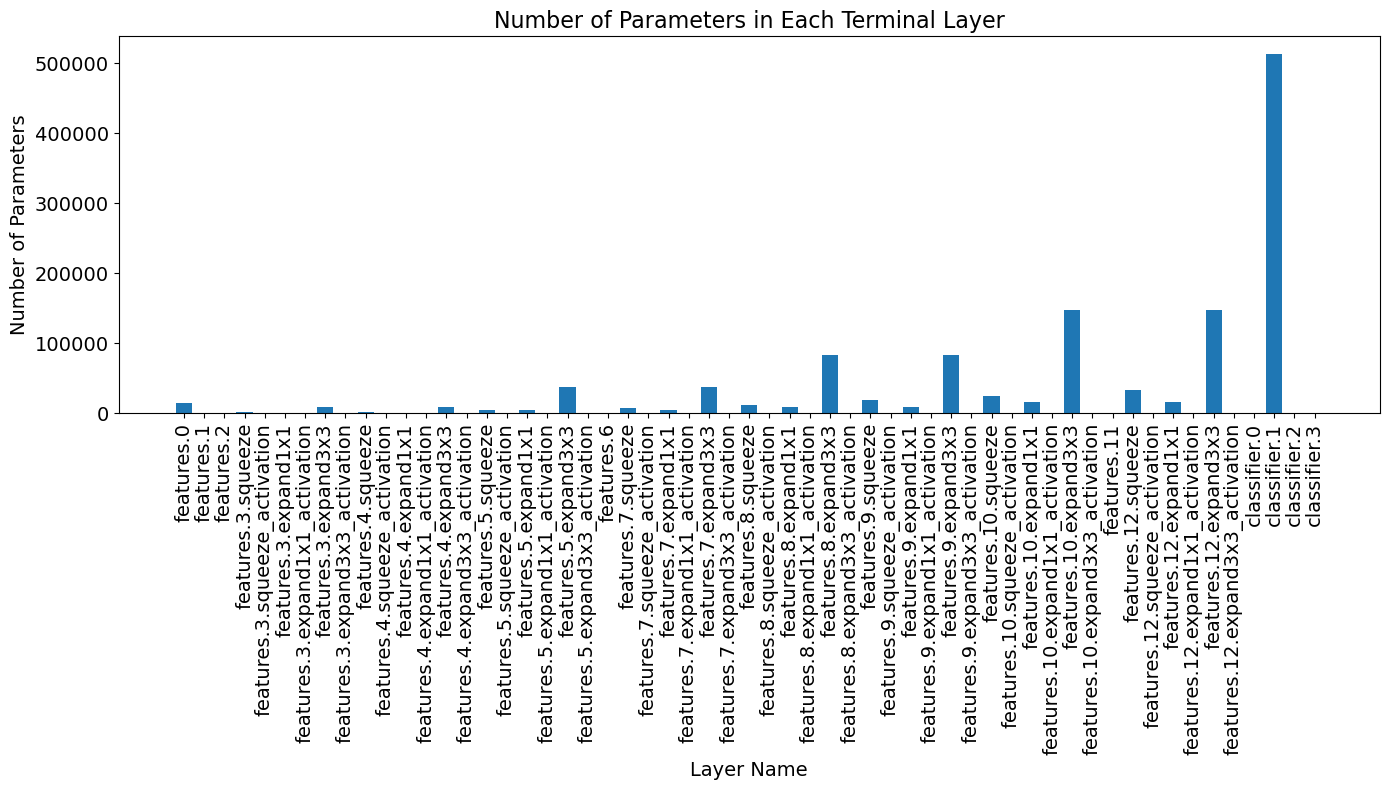

In [21]:
counting_params = {}

# For each terminal layer print its number of parameters
for layer in complex_model.named_modules():
    n_children = len(list(layer[1].children()))
    if n_children == 0:  # Terminal layer
        layer_name = layer[0]
        n_parameters = sum(p.numel() for p in layer[1].parameters())
        counting_params[layer_name] = n_parameters
        print(f"Layer {layer_name} has {n_parameters} parameters")

# Plotting the distribution of parameters per layer
helper_utils.plot_counting(counting_params)